In [ ]:
pip install shap

In [47]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import json
import shap

In [48]:
# Getting data from the JSON file
contents = []

try:
    with open("public_cases.json", 'r') as f:
        contents = json.load(f)
except Exception as e:
    print(e)

input = [item.get("input") for item in contents]

miles = [item.get("miles_traveled") for item in input]
days = [item.get("trip_duration_days") for item in input]
amount = [item.get("total_receipts_amount") for item in input]

target_feat = pd.DataFrame([item.get("expected_output") for item in contents])

# Convert data to data frame
data = {
    "miles_traveled": miles,
    "trip_duration_days": days,
    "total_receipts_amount": amount
}

descriptive_feats = pd.DataFrame(data)

In [ ]:
# Adding derived features
EPS = 1e-6  #small constant to avoid division-by-zero
descriptive_feats["cost_per_mile"] = descriptive_feats["total_receipts_amount"] / (descriptive_feats["miles_traveled"] + EPS)
descriptive_feats["cost_per_day"]  = descriptive_feats["total_receipts_amount"] / (descriptive_feats["trip_duration_days"] + EPS)
descriptive_feats["miles_per_day"] = descriptive_feats["miles_traveled"] / (descriptive_feats["trip_duration_days"] + EPS)
descriptive_feats["short_trip_flag"] = (descriptive_feats["miles_traveled"] < 100).astype(int)
descriptive_feats["long_trip_flag"] = (descriptive_feats["trip_duration_days"] >= 5).astype(int)

daily_cost = descriptive_feats["total_receipts_amount"] / (descriptive_feats["trip_duration_days"] + EPS)
descriptive_feats["high_daily_cost_flag"] = (daily_cost > 150).astype(int)

In [50]:
# Splitting data into testing and training (25% for testing)
X_train, X_test, y_train, y_test = train_test_split(descriptive_feats, target_feat, test_size=0.25, random_state=42)

In [51]:
# Creating and training the model

# n_estimators = number of trees in the forest
# oob_score = calculates an out-of-bag score
rf = RandomForestRegressor(n_estimators=100, random_state = 42, oob_score=True)

# Training the model
rf.fit(X_train, y_train)


c:\Users\sraza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(oob_score=True, random_state=42)

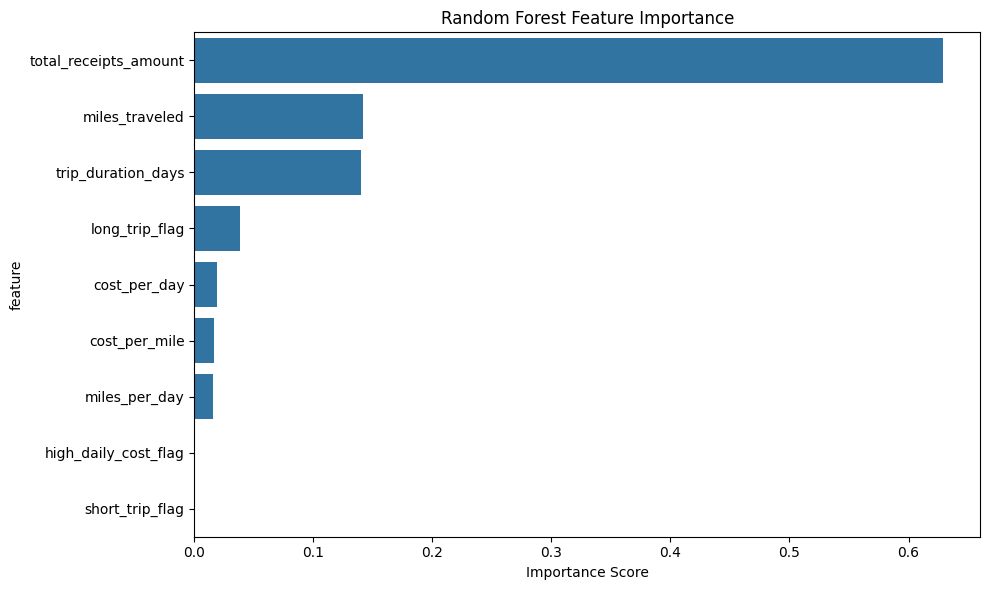

In [57]:
# Getting the feature importances from trained model
feat_impt = rf.feature_importances_
feat_names = descriptive_feats.columns

# Creating a DataFrame to plot feature importances
feat_imp_df = pd.DataFrame({'feature': feat_names, 'importance': feat_impt})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='importance', y='feature')
plt.title("Random Forest Feature Importance")
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


In [58]:
# Cross Validation Strategies
# Since there aren't any explicit timstamps, this data isn't time series aware

# Standard K-Fold Cross Validation (since data isn't time-series)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_mae = cross_val_score(rf, descriptive_feats, target_feat, cv=kf, scoring='neg_mean_absolute_error')
cv_scores_rmse = cross_val_score(rf, descriptive_feats, target_feat, cv=kf, scoring='neg_root_mean_squared_error')

print(f"CV MAE: {-cv_scores_mae.mean():.2f} (+/- {-cv_scores_mae.std() * 2:.2f})")
print(f"CV RMSE: {-cv_scores_rmse.mean():.2f} (+/- {-cv_scores_rmse.std() * 2:.2f})")

c:\Users\sraza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sraza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sraza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sraza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConvers

CV MAE: 82.08 (+/- -11.10)
CV RMSE: 134.82 (+/- -26.25)


In [59]:
# Multiple Evaluations Metrics

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

r_squared = rf.score(X_test, y_test)
print(f"R-Squared: {r_squared:4f}")

#Accuracy within a threshold (w/in 5% of actual value)
threshold = 0.05
within_threshold = np.abs((y_test - pd.DataFrame(y_pred)) / y_test) 
accuracy_within_threshold = np.mean(within_threshold) * 100
print(f"Accruacy within {threshold*100:.0f}%: {accuracy_within_threshold:.2f}%")


Mean Absolute Error (MAE): 73.95
Root Mean Squared Error (RMSE): 111.82
R-Squared: 0.940193
Accruacy within 5%: 80.87%


In [60]:
#Overfitting Detection and Prevention
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print("Overfitting Check")
print(f"Training Score: {train_score:.4f}")
print(f"Testing Score: {test_score:.4f}")

if abs(train_score - test_score) > 0.1:
    print("Model may be overfitting") 


Overfitting Check
Training Score: 0.9875
Testing Score: 0.9402


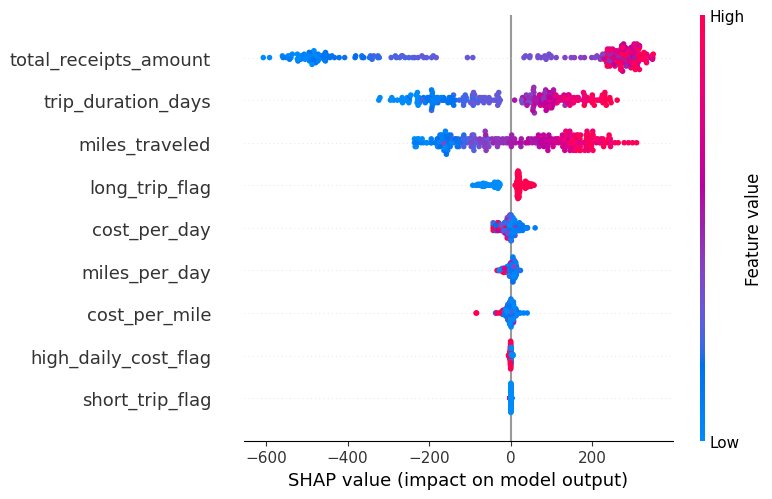

In [61]:
# Model interpretability analysis (using SHAP)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=["miles_traveled", "trip_duration_days", "total_receipts_amount", "cost_per_mile", "cost_per_day", "miles_per_day", "short_trip_flag", "long_trip_flag", "high_daily_cost_flag"])

SHAP (SHapley Additive exPlanations): A unified framework that assigns each feature an importance value for a single prediction, explaining why a specific prediction was made. The plot shows the following: 
- Feature importance (features are ordered by mean|SHAP value|).
- The impact of each feature on the model output (SHAP value).
- The original feature value (color) shows how high (red) or low (blue) a feature value pushes the prediction.